# Actividad 2: Policy Gradient en GridWorld con Obstáculos

Este notebook implementa un agente de Reinforcement Learning (Policy Gradient) en un entorno de GridWorld con obstáculos múltiples, basado en el ejemplo RFGradient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# ============================================
# Configuración del Entorno
# ============================================

GRID_SIZE = 9
N_STATES = GRID_SIZE * GRID_SIZE
N_ACTIONS = 4  # 0: up, 1: down, 2: left, 3: right

# Definición de Celdas Especiales
start_pos   = (0, 0)
object_pos  = (4, 3)  # Recoge objeto (recompensa intermedia)
goal_main   = (8, 8)  # Meta principal
goal_alt    = (8, 0)  # Meta alternativa

# Lista de obstáculos (Holes)
# Se pueden agregar más coordenadas aquí para aumentar la dificultad
holes_pos = [
    (4, 4), # Obstáculo original
    (2, 2),
    (2, 6),
    (6, 2),
    (6, 6),
    (4, 5),
    (5, 4)
]

# ============================================
# Utilidades
# ============================================

def pos_to_state(pos):
    r, c = pos
    return r * GRID_SIZE + c

def state_to_pos(s):
    return divmod(s, GRID_SIZE)

def softmax(logits):
    logits = logits - np.max(logits)
    exp = np.exp(logits)
    return exp / np.sum(exp)

# ============================================
# Dinámica del Entorno
# ============================================

def step_env(state, action, has_object):
    r, c = state_to_pos(state)

    # Movimiento
    if action == 0:   # up
        r = max(0, r - 1)
    elif action == 1: # down
        r = min(GRID_SIZE - 1, r + 1)
    elif action == 2: # left
        c = max(0, c - 1)
    elif action == 3: # right
        c = min(GRID_SIZE - 1, c + 1)

    new_pos = (r, c)
    new_state = pos_to_state(new_pos)

    reward = -0.01  # Pequeño coste por paso
    done = False
    outcome = 0  # 0: nada, -1: hoyo, 1: goal_main, 2: goal_alt

    # Verificación de estados terminales
    if new_pos in holes_pos:
        reward = -1.0
        done = True
        outcome = -1
    elif new_pos == goal_main:
        reward = 1.0
        done = True
        outcome = 1
    elif new_pos == goal_alt:
        reward = 0.4
        done = True
        outcome = 2

    # Recompensa por objeto (sólo la primera vez)
    if (not has_object) and (new_pos == object_pos):
        reward += 0.7
        has_object = True

    return new_state, reward, done, has_object, outcome


In [2]:
# ============================================
# Entrenamiento (REINFORCE)
# ============================================

np.random.seed(42) # Seed para reproducibilidad
theta = np.zeros((N_STATES, N_ACTIONS))
alpha = 0.1
gamma = 0.99
n_episodes = 10000
max_steps = 100

# Métricas e historial
returns_history = np.zeros(n_episodes)
goal_main_hits = np.zeros(n_episodes)
goal_alt_hits = np.zeros(n_episodes)
hole_hits = np.zeros(n_episodes)

episode_paths = []
episode_outcomes = []

print(f"Iniciando entrenamiento por {n_episodes} episodios...")

for ep in range(n_episodes):
    state = pos_to_state(start_pos)
    has_object = False

    states = []
    actions = []
    rewards = []

    path = [state_to_pos(state)]
    outcome_ep = 0

    for t in range(max_steps):
        probs = softmax(theta[state])
        action = np.random.choice(N_ACTIONS, p=probs)

        next_state, reward, done, has_object, outcome = step_env(state, action, has_object)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state
        path.append(state_to_pos(state))

        if done:
            outcome_ep = outcome
            break

    episode_paths.append(path)
    episode_outcomes.append(outcome_ep)

    # Calculo de Retornos G_t
    T = len(rewards)
    G = 0
    returns = np.zeros(T)
    for t in reversed(range(T)):
        G = rewards[t] + gamma * G
        returns[t] = G

    returns_history[ep] = np.sum(rewards)

    # Registro de estadísticas
    if outcome_ep == 1:
        goal_main_hits[ep] = 1
    elif outcome_ep == 2:
        goal_alt_hits[ep] = 1
    elif outcome_ep == -1:
        hole_hits[ep] = 1

    # Actualización de Gradiente (REINFORCE)
    grad = np.zeros_like(theta)
    for t in range(T):
        s = states[t]
        a = actions[t]
        Gt = returns[t]

        probs = softmax(theta[s])
        one_hot = np.zeros(N_ACTIONS)
        one_hot[a] = 1.0

        grad[s] += Gt * (one_hot - probs)

    if T > 0:
        theta += alpha * grad / T
        
    if (ep + 1) % 1000 == 0:
        print(f"Episodio {ep+1}/{n_episodes} completado.")

print("Entrenamiento finalizado.")

Iniciando entrenamiento por 10000 episodios...
Episodio 1000/10000 completado.
Episodio 2000/10000 completado.
Episodio 3000/10000 completado.
Episodio 4000/10000 completado.
Episodio 5000/10000 completado.
Episodio 6000/10000 completado.
Episodio 7000/10000 completado.
Episodio 8000/10000 completado.
Episodio 9000/10000 completado.
Episodio 10000/10000 completado.
Entrenamiento finalizado.


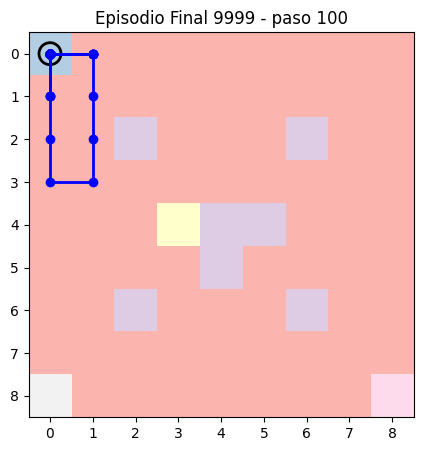

In [3]:
# ============================================
# Visualización del Mapa y Resultados
# ============================================

grid_map = np.zeros((GRID_SIZE, GRID_SIZE))
grid_map[start_pos]  = 1  # inicio
for hole in holes_pos:
    grid_map[hole]   = 2  # hoyos (obstáculos)
grid_map[object_pos] = 3  # objeto
grid_map[goal_main]  = 4  # meta principal
grid_map[goal_alt]   = 5  # meta alternativa

def animate_episode(ep_idx, pause=0.1, title_prefix="Episodio"):
    path = episode_paths[ep_idx]
    all_x = [c for (r, c) in path]
    all_y = [r for (r, c) in path]

    fig, ax = plt.subplots(figsize=(5, 5))

    for t in range(len(path)):
        clear_output(wait=True)
        ax.clear()
        ax.imshow(grid_map, origin="upper", cmap='Pastel1') # cmap para distinguir colores
        
        # Ruta
        ax.plot(all_x[:t+1], all_y[:t+1], marker='o', linestyle='-', linewidth=2, color='blue')
        
        # Posición actual
        r, c = path[t]
        ax.scatter([c], [r], s=250, edgecolors='k', linewidths=2, facecolors='none')

        ax.set_title(f"{title_prefix} {ep_idx} - paso {t}")
        ax.set_xticks(range(GRID_SIZE))
        ax.set_yticks(range(GRID_SIZE))
        
        display(fig)
        time.sleep(pause)

    plt.close(fig)

# Visualizar últimos episodios (post-entrenamiento)
animate_episode(n_episodes - 1, pause=0.1, title_prefix="Episodio Final")

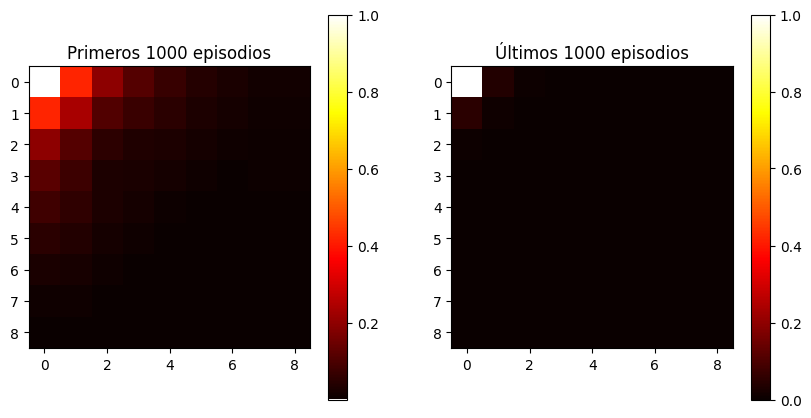

In [4]:
def compute_visit_counts(paths_subset):
    counts = np.zeros((GRID_SIZE, GRID_SIZE))
    for path in paths_subset:
        for (r, c) in path:
            counts[r, c] += 1
    return counts

def safe_normalize(mat):
    m = mat.max()
    if m > 0:
        return mat / m
    return mat

def plot_visit_heatmaps(num_early=100, num_late=100):
    n_eps = len(episode_paths)
    early_end = min(num_early, n_eps)
    late_start = max(0, n_eps - num_late)

    early_counts = compute_visit_counts(episode_paths[:early_end])
    late_counts  = compute_visit_counts(episode_paths[late_start:])

    early_norm = safe_normalize(early_counts)
    late_norm  = safe_normalize(late_counts)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    im1 = ax1.imshow(early_norm, origin="upper", cmap='hot')
    ax1.set_title(f"Primeros {early_end} episodios")
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(late_norm, origin="upper", cmap='hot')
    ax2.set_title(f"Últimos {n_eps - late_start} episodios")
    fig.colorbar(im2, ax=ax2)
    
    plt.show()

plot_visit_heatmaps(num_early=1000, num_late=1000)